In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

np.random.seed(592)

Here we implement Exp3 to reconstruct the figure from Problem 2:

In [3]:
def exp3_p2(horizon, num_repitions, alpha):
    regret = np.zeros(num_repitions)

    #loss of arm 1 is 0 for t<horizon/2 and 1 for t>=horizon/2
    arm1_loss = np.zeros(horizon)
    arm1_loss[horizon//2:] = 1

    #los of arm 2 is alpha for t<horizon/2 and 0 for t>=horizon/2
    arm2_loss = np.zeros(horizon)
    arm2_loss[:horizon//2] = alpha    

    #learning rate is sqrt(2log(k)/(nK))
    eta = np.sqrt(2 * np.log(2) / (horizon * 2))

    for i in tqdm(range(num_repitions)):
        #initialize weights
        arm1_weight = arm2_weight = 1

        for t in range(horizon):
            total_weight = arm1_weight + arm2_weight

            prob_arm1 = arm1_weight / total_weight
            prob_arm2 = arm2_weight / total_weight

            #choose arm ny sampling, for two arms we can do this easily 
            #also the estimator is only nonzero for the arm we select so only the weight of that arm changes
            if np.random.rand() < prob_arm1:
                loss = arm1_loss[t]
                arm1_weight *= np.exp(-eta * loss / prob_arm1)
            else:
                loss = arm2_loss[t]
                arm2_weight *= np.exp(-eta * loss / prob_arm2)
            
            #update the regret
            regret[i] +=  loss - arm2_loss[t]

    return regret 

In [4]:
def plot_box_whisker(horizon, num_repitions):
    regret_28 = exp3_p2(horizon=10000, num_repitions=num_repitions, alpha=0.28)   
    regret_285 = exp3_p2(horizon=10000, num_repitions=num_repitions, alpha=0.285)
    regret_29 = exp3_p2(horizon=10000, num_repitions=num_repitions, alpha=0.29)
    regret_295 = exp3_p2(horizon=10000, num_repitions=num_repitions, alpha=0.295)
    regret_3 = exp3_p2(horizon=10000, num_repitions=num_repitions, alpha=0.3)

    plt.figure(figsize=(10, 6))
    plt.boxplot([regret_28, regret_285, regret_29, regret_295, regret_3], 
                labels=['0.28', '0.285', '0.29', '0.295', '0.3'], 
                whiskerprops=dict(color='black'),
                patch_artist=True,
                showmeans=True,
                meanprops=dict(marker='D', markeredgecolor='black', markerfacecolor='grey'),)
    plt.xlabel('Alpha')
    plt.ylabel('Regret')
    plt.title('Regret of Exp3 for Different Alpha Values')
    plt.grid(axis='y', linestyle='--')
    plt.show()

100%|██████████| 500/500 [00:16<00:00, 29.80it/s]
/var/folders/mf/2cn54l592v59ftz5czx_4x_m0000gn/T/ipykernel_96557/4189364639.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([regret_28, regret_285, regret_29, regret_295, regret_3],


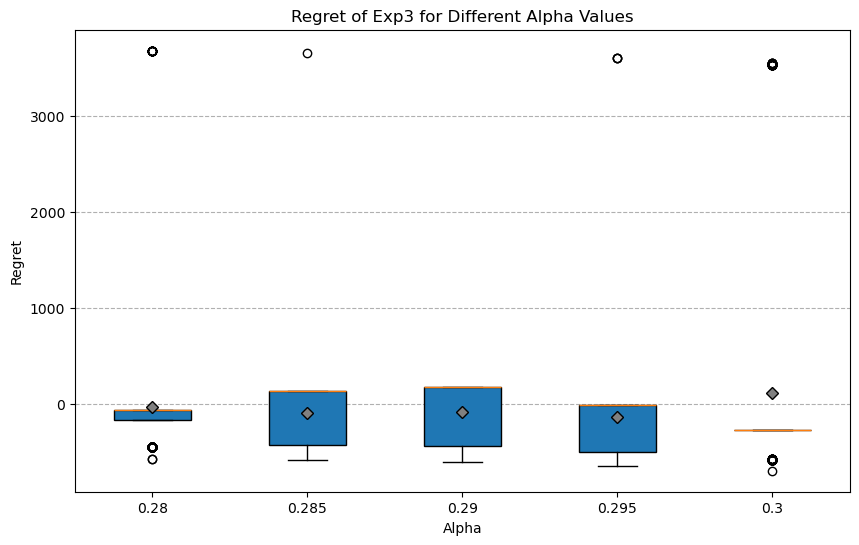

In [5]:
plot_box_whisker(horizon=10000, num_repitions=500)

Now we will implement Exp3 and UCB for Problem 3:

In [32]:
def exp3_p3(horizon, num_repitions, delta, eta=None):
    regret = np.zeros(num_repitions)

    arm1_mean = 0.5
    arm2_mean = 0.5 + delta

    #learning rate is sqrt(2log(k)/(nK))
    if eta is None:
        eta = np.sqrt(2 * np.log(2) / (horizon * 2))

    for i in tqdm(range(num_repitions)):
        #initialize weights
        arm1_weight = arm2_weight = 1

        for t in range(horizon):
            total_weight = arm1_weight + arm2_weight

            prob_arm1 = arm1_weight / total_weight
            prob_arm2 = arm2_weight / total_weight

            #choose arm ny sampling, for two arms we can do this easily 
            #also the estimator is only nonzero for the arm we select so only the weight of that arm changes
            if np.random.rand() < prob_arm1:
                reward = np.random.binomial(1, arm1_mean)       
                exponent = np.clip(eta * reward / prob_arm1, -10, 10)
                arm1_weight *= np.exp(exponent)
                #update the regret
                regret[i] +=  arm2_mean - arm1_mean
            else:
                reward = np.random.binomial(1, arm2_mean)       
                exponent = np.clip(eta * reward / prob_arm2, -10, 10)
                arm2_weight *= np.exp(exponent)

    return regret 

In [15]:
def ucb_p3(horizon, num_repitions, delta):
    regret = np.zeros(num_repitions)

    arm1_mean = 0.5
    arm2_mean = 0.5 + delta

    arm1_mean_est = 0
    arm2_mean_est = 0
    arm1_count = 0
    arm2_count = 0
    arm1_total_reward = 0
    arm2_total_reward = 0

    arm1_ucb = 0
    arm2_ucb = 0

    for i in tqdm(range(num_repitions)):
        for t in range(horizon):
            
            #pull each arm at least once
            if t == 0:
                arm1_count += 1
                reward = np.random.binomial(1, arm1_mean)
                arm1_total_reward += reward
                arm1_mean_est = arm1_total_reward / arm1_count
                arm1_ucb = arm1_mean_est + np.sqrt(2 * np.log(2*(horizon**2)*2) / arm1_count)

                regret[i] += arm2_mean - arm1_mean

                arm2_count += 1
                reward = np.random.binomial(1, arm2_mean)
                arm2_total_reward += reward
                arm2_mean_est = arm2_total_reward / arm2_count
                arm2_ucb = arm2_mean_est + np.sqrt(2 * np.log(2*(horizon**2)*2) / arm2_count)
            else:
                if arm1_ucb > arm2_ucb:
                    arm1_count += 1
                    reward = np.random.binomial(1, arm1_mean)
                    arm1_total_reward += reward
                    arm1_mean_est = arm1_total_reward / arm1_count
                    arm1_ucb = arm1_mean_est + np.sqrt(2 * np.log(2*(horizon**2)*2) / arm1_count)

                    regret[i] +=  arm2_mean - arm1_mean
                else:
                    arm2_count += 1
                    reward = np.random.binomial(1, arm2_mean)
                    arm2_total_reward += reward
                    arm2_mean_est = arm2_total_reward / arm2_count
                    arm2_ucb = arm2_mean_est + np.sqrt(2 * np.log(2*(horizon**2)*2) / arm2_count)

    return regret

In [16]:
def plot_a(num_repititions, delta):
    """
    Plot the regret of UCB and Exp3 on the same plot as a function of the horizon n
    """
    #10 evenly spaced horizons between 1000 and 10000
    horizons = np.linspace(1000, 10000, 10)

    ucb_regret = np.zeros(len(horizons))
    exp3_regret = np.zeros(len(horizons))

    for i, horizon in enumerate(horizons):
        ucb_regret[i] = np.mean(ucb_p3(horizon=int(horizon), num_repitions=num_repititions, delta=delta))
        exp3_regret[i] = np.mean(exp3_p3(horizon=int(horizon), num_repitions=num_repititions, delta=delta))

    plt.figure(figsize=(10, 6))
    plt.plot(horizons, ucb_regret, label='UCB', marker='o')
    plt.plot(horizons, exp3_regret, label='Exp3', marker='o')
    plt.xlabel('Horizon')
    plt.ylabel('Regret')
    plt.title('Regret of UCB and Exp3 as a Function of Horizon')
    plt.legend()
    plt.grid()
    plt.show()

100%|██████████| 50/50 [00:01<00:00, 25.07it/s]


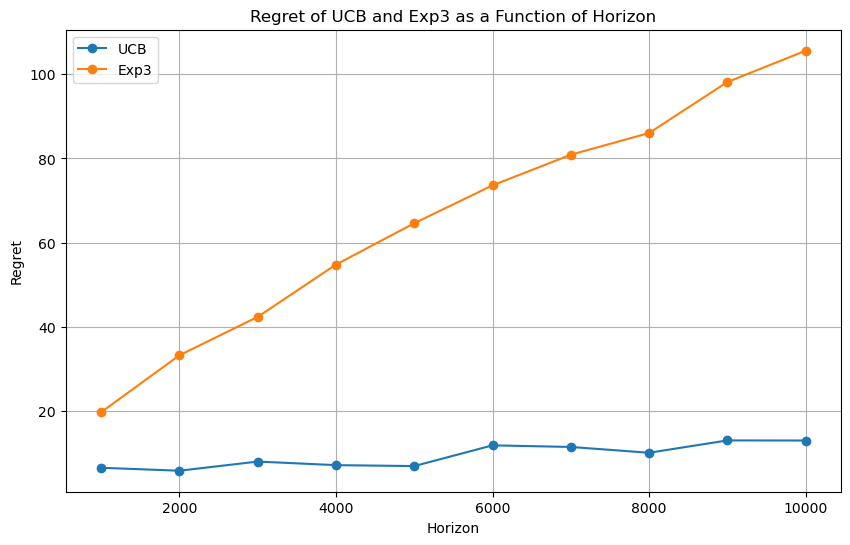

In [17]:
plot_a(num_repititions=50, delta=0.05)

In [33]:
def plot_b(num_repititions, delta):
    """
    Fix the horizon to n = 10000 and plot the regret of exp3 as a function of the learning rate
    """

    #30 evenly spaced learning rates between 0.01 and 0.1
    learning_rates = np.linspace(0.0001, 0.1, 30)

    regrets = np.zeros(len(learning_rates))

    for i, eta in enumerate(learning_rates):
        regrets[i] = np.mean(exp3_p3(horizon=10000, num_repitions=num_repititions, delta=delta, eta=eta))

    plt.figure(figsize=(10, 6))
    plt.plot(learning_rates, regrets, marker='o')
    plt.xlabel('Learning Rate')
    plt.ylabel('Regret')
    plt.title('Regret of Exp3 as a Function of Learning Rate')
    plt.grid()
    plt.show()


100%|██████████| 100/100 [00:10<00:00,  9.96it/s]


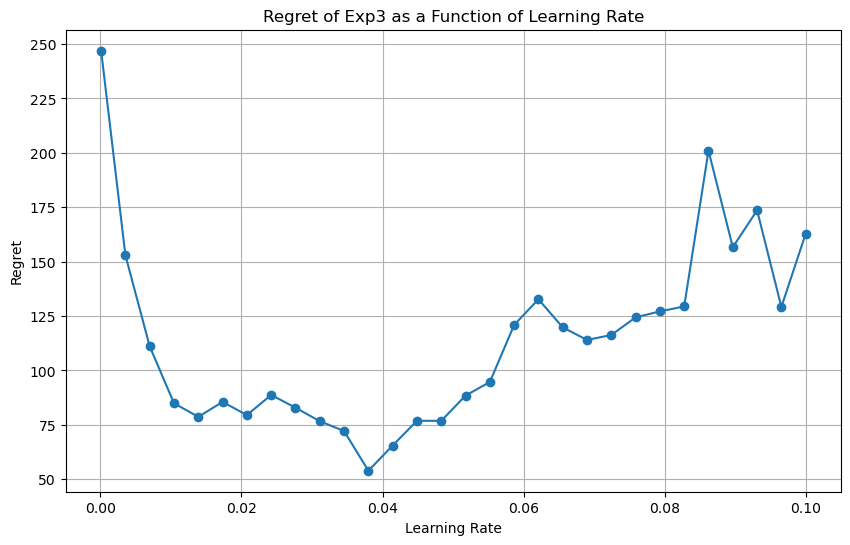

In [36]:
plot_b(num_repititions=100, delta=0.05)

In [43]:
def plot_c(num_repititions):
    """
    Fix the horizon to n = 10000 and plot the regret of exp3 as a function of the learning rate for different deltas 
    """
    #5 evenly spaced deltas between 0.05 and 0.4
    deltas = np.linspace(0.05, 0.4, 5)

    #30 evenly spaced learning rates between 0.01 and 0.1
    learning_rates = np.linspace(0.0001, 0.1, 30)

    for delta in deltas:
        regrets = np.zeros(len(learning_rates))

        for i, eta in enumerate(learning_rates):
            regrets[i] = np.mean(exp3_p3(horizon=1000, num_repitions=num_repititions, delta=round(delta, 2), eta=eta))

        plt.plot(learning_rates, regrets, label=f'Delta = {round(delta, 2)}', marker='o')
    
    plt.xlabel('Learning Rate')
    plt.ylabel('Regret')
    plt.title('Regret of Exp3 as a Function of Learning Rate for Different Deltas')
    plt.legend()
    plt.grid()
    plt.show()

100%|██████████| 50/50 [00:00<00:00, 99.98it/s] 


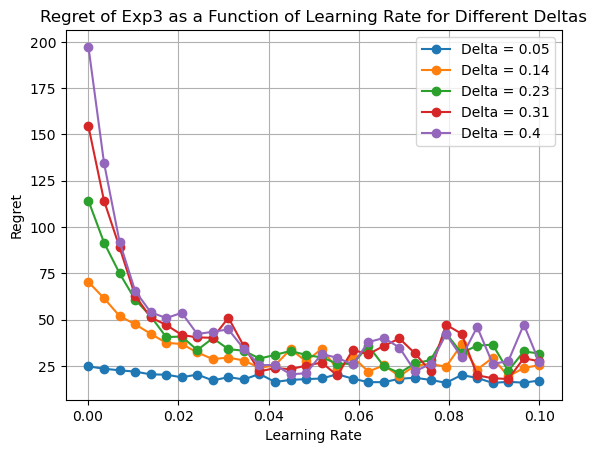

In [44]:
plot_c(num_repititions=50)

To find the choice of learning rate that minimizes the regret over all reasonable delta, we will compute the average regret across different values of delta for each learning rate in the plot above. 

100%|██████████| 50/50 [00:00<00:00, 97.88it/s]


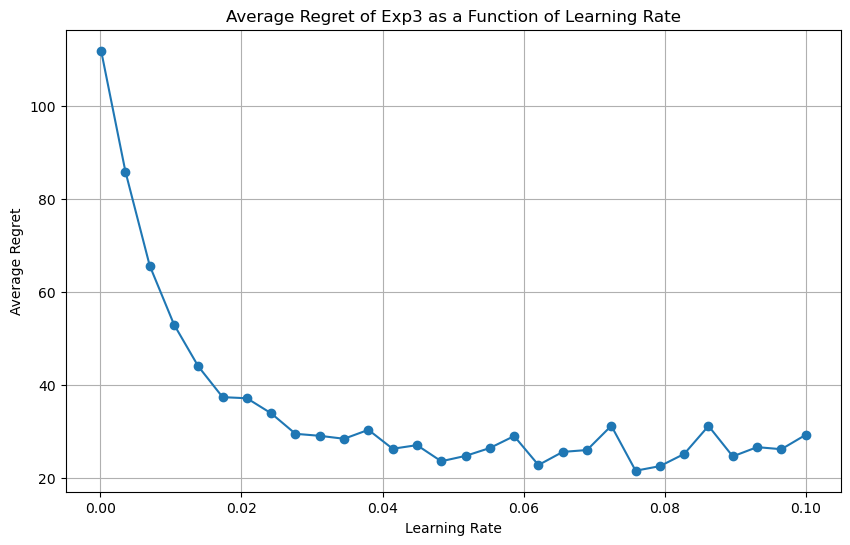

In [48]:
#5 evenly spaced deltas between 0.05 and 0.4
deltas = np.linspace(0.05, 0.4, 5)

#30 evenly spaced learning rates between 0.01 and 0.1
learning_rates = np.linspace(0.0001, 0.1, 30)
learning_rate_avg_regret = np.zeros(len(learning_rates))

for i, eta in enumerate(learning_rates):
    regrets = np.zeros(len(deltas))

    for j, delta in enumerate(deltas):
        regrets[j] = np.mean(exp3_p3(horizon=1000, num_repitions=50, delta=round(delta, 2), eta=eta))

    learning_rate_avg_regret[i] = np.mean(regrets)

plt.figure(figsize=(10, 6))
plt.plot(learning_rates, learning_rate_avg_regret, marker='o')
plt.xlabel('Learning Rate')
plt.ylabel('Average Regret')
plt.title('Average Regret of Exp3 as a Function of Learning Rate')
plt.grid()
plt.show()

Now we compare to the theoretical value:

In [49]:
np.sqrt(2*np.log(2)/1000*2)

0.05265537695468319